### importing packages

In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
path = "../aerial-cactus-identification"

In [98]:
from PIL import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

### Setting directories

In [55]:
# setting directories
train_dir = '/input/train/'
test_dir = '/input/test/'
train = pd.read_csv('train.csv')

### Exploring the dataset

In [30]:
# explore the data
train.head(10)                # when image contains cactus 1, otherwise 0

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [33]:
train.dtypes                  # check the data type

id            object
has_cactus     int64
dtype: object

In [92]:
train.has_cactus = train.has_cactus.apply(str)   # since the column is not about integer values, 
train.dtypes                  # change the column data type to string

id            object
has_cactus    object
dtype: object

17500
1    13136
0     4364
Name: has_cactus, dtype: int64


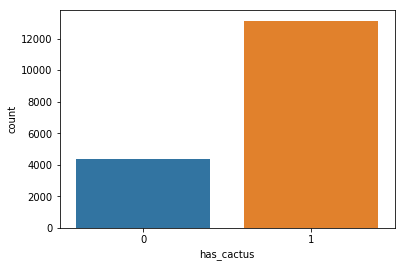

In [32]:
print(len(train))                              # number of observation: 17,500
print(train['has_cactus'].value_counts() )     # count the number of images containing cactus
sns.countplot(x='has_cactus', data=train)      # plot the output

In [58]:
# check the test dataset size
print('the number of rows in test set:', len(os.listdir(path+test_dir)))

the number of rows: 4000


### Showing the random images

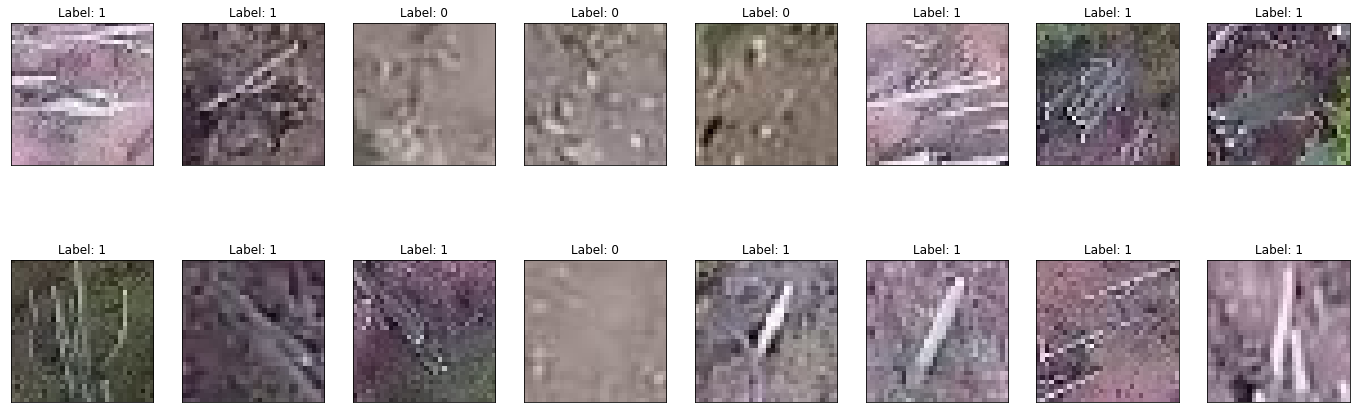

In [85]:
fig = plt.figure(figsize=(24, 8))
for idx, img in enumerate(np.random.choice(os.listdir(path+train_dir), 16)):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    im = PIL.Image.open(path+train_dir+ img)
    plt.imshow(im)
    lab = train.loc[train['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

### Preparing the dataset

In [87]:
data = ImageDataGenerator(rescale=1./255)
batch_size = 100

<b> flow_from_dataframe method </b> can directly pass the Pandas DataFrame which has the mapping between filenames of the images and their labels. <br>
The flow_from_dataframe accepts all the arguments that flow_from_directory accepts,and obvious mandatory arguments like
- dataframe- Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
- directory- Path to the folder which contains all the images,None if x_col contains absolute paths pointing to each image instead of just filenames.
- x_col- The column in the dataframe that has the filenames of the images
- y_col- The column/columns in the dataframe in the filename that will be treated as raw target values if class_mode=”raw” (useful for regression tasks) or they will be treated as name of the classes if class_mode is “binary”/”categorical” or they will be ignored if class_mode is “input”/None.
- class_mode- In addition to all the class_modes previously available in flow_from_directory, there is “raw”.
- drop_duplicates- Boolean, whether to drop duplicate rows based on filename,True by default. <br>

Source: https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1


In [95]:
# Split the dataset into training and validation sets
train_generator=data.flow_from_dataframe(dataframe=train[:15001],
                                         directory=path+train_dir,
                                         x_col='id',
                                         y_col='has_cactus',
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(150,150))

val_generator=data.flow_from_dataframe(dataframe=train[15000:],
                                         directory=path+train_dir,
                                         x_col='id',
                                         y_col='has_cactus',
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(150,150))

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Building models

In [99]:
# build a model
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
__________

In [101]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.rmsprop(), metrics=['acc'])

In [103]:
# fit the model 
epochs = 5
model_fit = model.fit_generator(train_generator,steps_per_epoch=100,epochs=5,
                                validation_data = val_generator,validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
100/100 [==============================] - 281s 3s/step - loss: 2.9530 - acc: 0.7412 - val_loss: 0.3114 - val_acc: 0.7532
Epoch 2/5
100/100 [==============================] - 265s 3s/step - loss: 0.3024 - acc: 0.8796 - val_loss: 0.1535 - val_acc: 0.9436
Epoch 3/5
100/100 [==============================] - 271s 3s/step - loss: 0.1967 - acc: 0.9202 - val_loss: 0.1281 - val_acc: 0.9496
Epoch 4/5
100/100 [==============================] - 273s 3s/step - loss: 0.1380 - acc: 0.9487 - val_loss: 0.0824 - val_acc: 0.9688
Epoch 5/5
100/100 [==============================] - 273s 3s/step - loss: 0.1107 - acc: 0.9605 - val_loss: 0.0839 - val_acc: 0.9696


In [130]:
# Evaluate the model 
def plot_metric(df, col, val_col, epochs, label, val_label):
    acc = df.history[col]
    epo = range(0, epochs)
    plt.plot(epo, acc, label=label)
    
    val_col=df.history[val_col]
    plt.scatter(epo, val_col, label=val_label)
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()

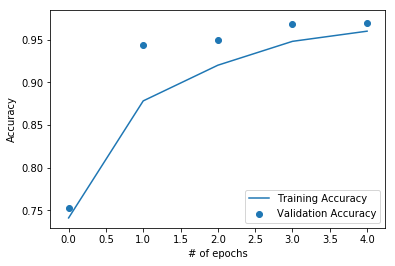

In [131]:
plot_metric(model_fit,'acc', 'val_acc', epochs,'Training Accuracy', 'Validation Accuracy')

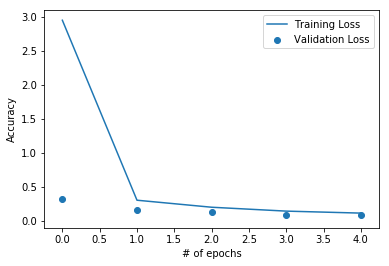

In [132]:
plot_metric(model_fit,'loss', 'val_loss', epochs,'Training Loss', 'Validation Loss')